# Lesson 2: Introduction to git, optimization, and spikes

## Lesson goals:

1. Install PyCharm and configure a project with Github integration for this code repository
2. git commands: pull, stash, add, commit, merge, push
3. Introduction to function optimization with scipy.optimize
4. Perform bounded parameter optimization on the input resistance of a NEURON section
5. Introduction to NMODL, the language used to specify ion channel mechanisms in NEURON
6. Insert "active" voltage-dependent "Hodgkin-Huxley" ion channels
7. Challenge 1: Measure and plot an "f-I curve"
8. Challenge 2: Simultaneously optimize both somatic input resistance and the slope of the f-I curve.

## 1. Install PyCharm and configure a project with Github integration for this code repository

https://www.jetbrains.com/pycharm/download/#section=mac

### In Pycharm:
- Top Menu --> File --> New Project...
- Set "Location" to directory containing nrnpy_tutorial repository
- Set "Python Interpreter" to "Existing Interpreter" and point to python executable in anaconda bin directory
- "Create"
- "Create from existing sources"
- Open project in "New Window"
- Let PyCharm find importable python modules and do some indexing
<br><br>
- Top Menu --> PyCharm --> Preferences...
- Project:nrnpy_tutorial --> Python Interpreter
- Click settings gear on top right --> "Show All"
- Click directory hierarchy icon on bottom "Show paths for the selected interpreter"
- If not already in the list, make sure to "Add" the "parent directory" that contains the subdirectory with your cloned git repository
- Back in the Preferences panel --> Tools --> Terminal
- Make sure the "Shell path" points to your preferred bash executable (e.g. /bin/zsh)
- Apply and close Preferences
<br><br>
- Click the "Terminal" tab on the bottom
- `which python3` to make sure PyCharm Terminal agrees with the system terminal configuration
<br><br>
- Top Menu --> VCS --> Git --> Remotes
- Make sure a remote location with the name "origin" points to the URL of the nrnpy_tutorial on GitHub

## 2. git commands: pull, stash, add, commit, merge, push

- `git pull origin master` - download any changes to the branch with the name "master" from the remote location named "origin" since you cloned the repository, or since the last time you "pulled"
    - PyCharm will warn you if you have made local changes that would be over-written by the pull operation
- `git stash` - if you want the remote changes to replace your local copy, you can "stash" the changes. On the next pull, your local changes will be over-written
- `git add` - if you want a file that you created to be tracked by git, you can right-click on the filename and "add" it the list of tracked files
- `git commit` - if you have made changes to one or more tracked files locally and you want to update the remote repository, you need to "commit" them to the record. This is just a local operation and does not yet change the upstream remote origin. You can add a message to describe the changes in this commit, and attribute yourself as the author of the changes.
- `git pull` - if in your latest commits, you have made changes to the same lines of the same files as another collaborator, and you try to "pull" remote changes, PyCharm will detect the conflict and give you the opportunity to decide line-by-line which version you would like to use going forward. This is called a "merge" operation.
- `git push` - Once you have merged, commit your changes again. Then you are ready to "push" those commits to the remote origin.

### Don't worry, everything you do with git is (usually) reversible!

## 3. Introduction to function optimization with scipy.optimize

Resource: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Let's say we have a function that takes an array of free parameters, and produces a single float output:

<IPython.core.display.Javascript object>


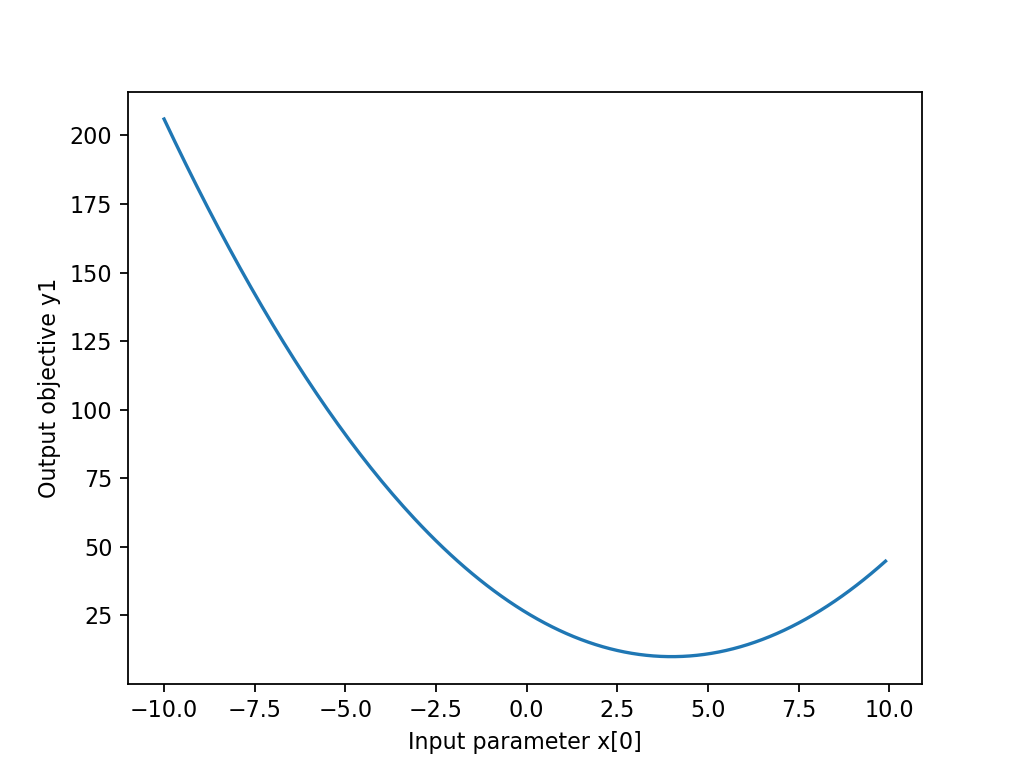

In [2]:
def y1(x):
    """
    The argument 'x' is an array of length 1.
    """
    y = (x[0] - 4) ** 2. + 10. #at minimum is 10
    return y

#test_x array x values to test
test_x = np.arange(-10., 10., 0.1)
#y wants x to be an array of length 1
test_y1 = [y1([xi]) for xi in test_x]
plt.figure()
plt.plot(test_x, test_y1)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y1')
plt.show()

Since this is a simple function, we could obtain the global minimum by graphing the function, or by solving the equation analytically. But when functions are complex, numerical optimization methods become useful tools to search for approximate local minimums.

scipy.optimize.minimize is a general interface that can use many different algorithms to search for input parameters that minimize a provided function. 

In [3]:
from scipy.optimize import minimize
# initial guess for the input parameter
#Will take based on specific convergence criteria (converge on the minimum)
#BFDGS initially
#where to start
x0 = 0.

result = minimize(y1, [x0], options={'disp': True})

Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4


In [4]:
print(result)
#hessian inverse () ; jacobian (first derative - slope of tangent line) - involves multiple parameters and elements, gradient
#gradient information - how much change to follow the shape of the slope from the function of multiple 
#parameter array based on x y and z 
#multiple objects: shower example, water pressure and heat with two knobs - gradient can work
#Neuron - leak conductance can vary and time constant 
#must do everything serially for simulations 
#12 function evals but not saved parameters

      fun: 10.000000000000002
 hess_inv: array([[0.49999999]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([3.99999995])


Well that was easy. But how do we know what parameters it tested? We'll have to manually keep track by appending the values to a global variable:

Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4


<IPython.core.display.Javascript object>


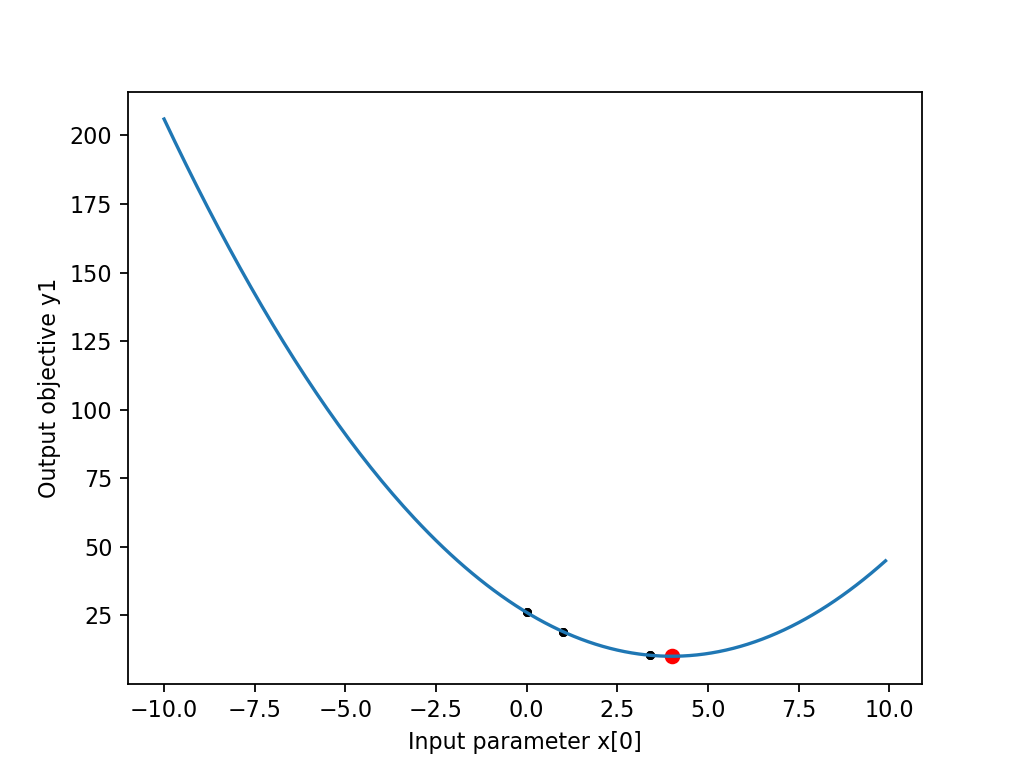

[3.99999995] 10.000000000000002


In [5]:
#global list variables, cannot be a float because they dont index values, 
#list and array can append values within a function
x_history = []
y_history = []

def y1(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    y = (x[0] - 4) ** 2. + 10.
    y_history.append(y)
    return y

result = minimize(y1, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], yi, marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y1)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y1')
plt.show()

print(result.x, result.fun)
#three iterations tested x plotted three points
#functions done 12 times to construct slope

What if there is no true global minimum?

In [6]:
def y2(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    #exponential decay
    y = np.exp(-x[0])
    y_history.append(y)
    return y

test_y2 = [y2([xi]) for xi in test_x]

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 17
         Function evaluations: 54
         Gradient evaluations: 18


<IPython.core.display.Javascript object>


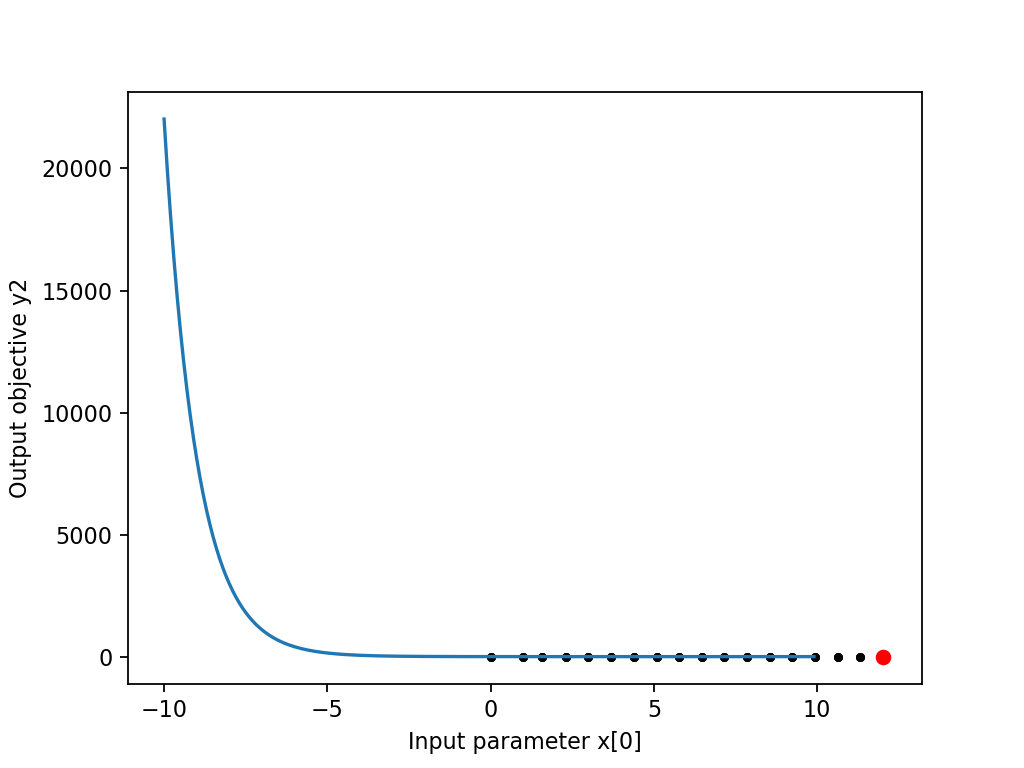

[12.01100351] 6.076975025331183e-06


In [7]:
x_history = []
y_history = []
result = minimize(y2, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)
#final error - function evaluation values

If there is no true global minimum, minimize will find a local one up to some error tolerance.

Optimization terminated successfully.
         Current function value: 0.098366
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4


<IPython.core.display.Javascript object>


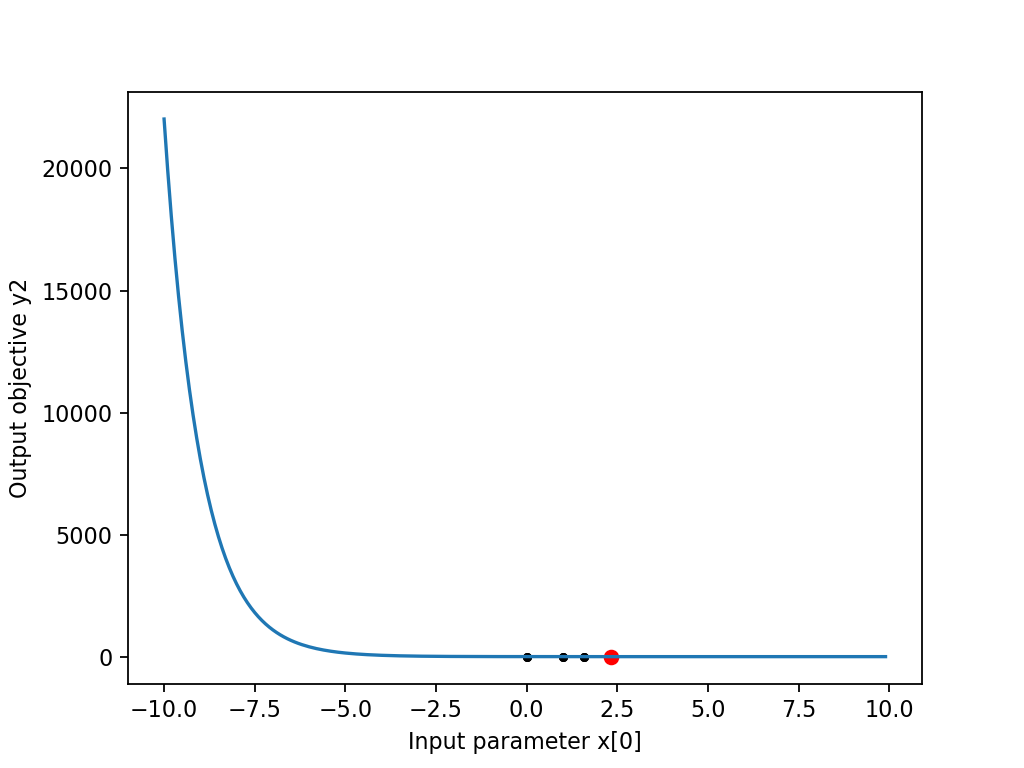

[2.31905503] 0.09836649465947296


In [8]:
x_history = []
y_history = []
#tolerance - relative improvement- setting a ceiling value
#or max iter
result = minimize(y2, [x0], options={'disp': True}, tol=0.1)

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 123
         Gradient evaluations: 41


<IPython.core.display.Javascript object>


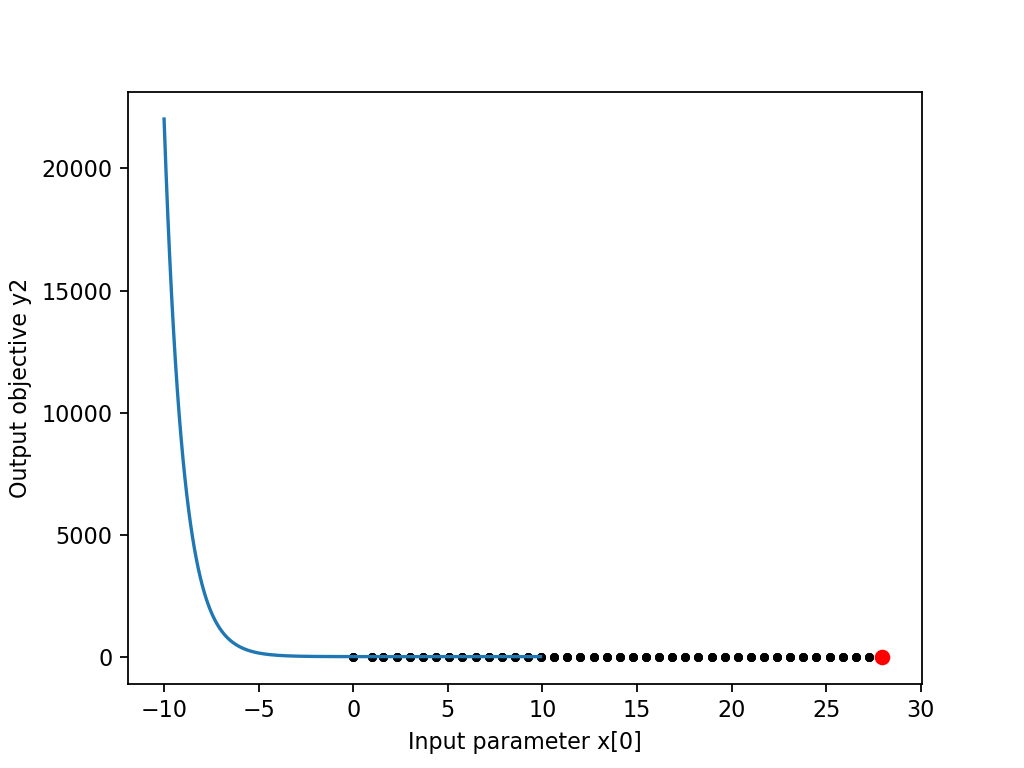

[27.95338864] 7.24431896631524e-13


In [9]:
x_history = []
y_history = []
result = minimize(y2, [x0], options={'disp': True}, tol=1e-12)

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)
#[xinput] , y

What if the function has multiple local minima?

In [10]:
def y3(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    #oscillation
    y = np.sin(x[0])
    y_history.append(y)
    return y

test_y3 = [y3([xi]) for xi in test_x]

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 4
         Function evaluations: 18
         Gradient evaluations: 6


<IPython.core.display.Javascript object>


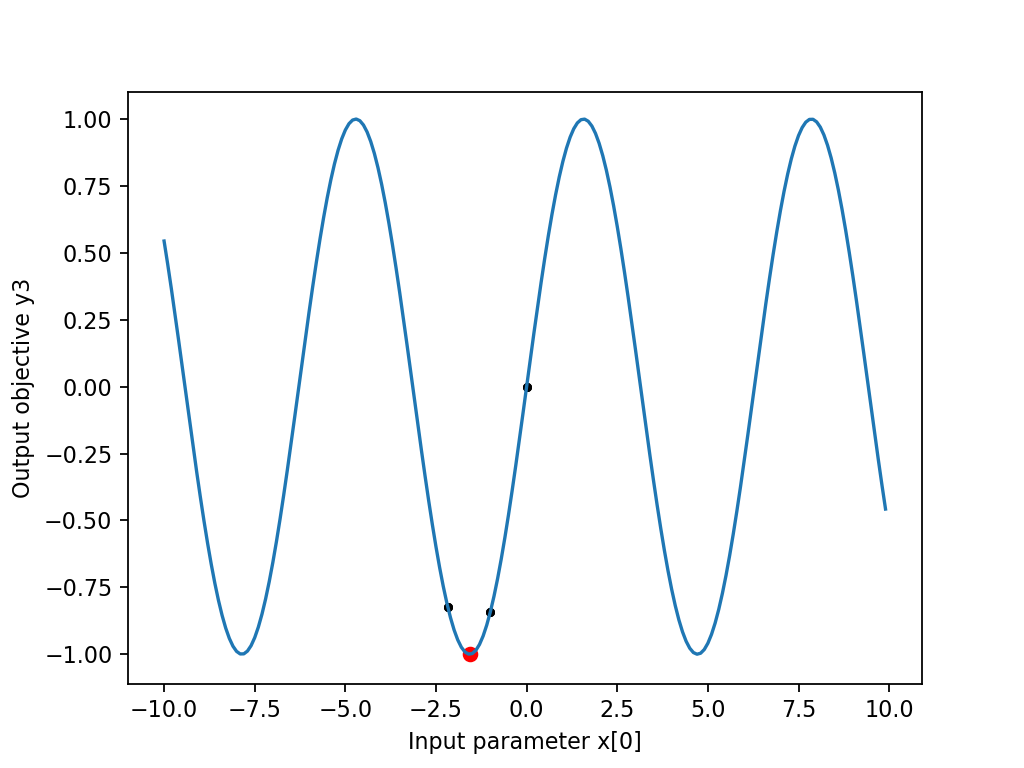

[-1.57079633] -1.0


In [11]:
x_history = []
y_history = []
result = minimize(y3, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)
#tested at 0 found slope and then found local minimum

If the function has multiple local minima, the search can be limited to a bounded range of parameters:

<IPython.core.display.Javascript object>


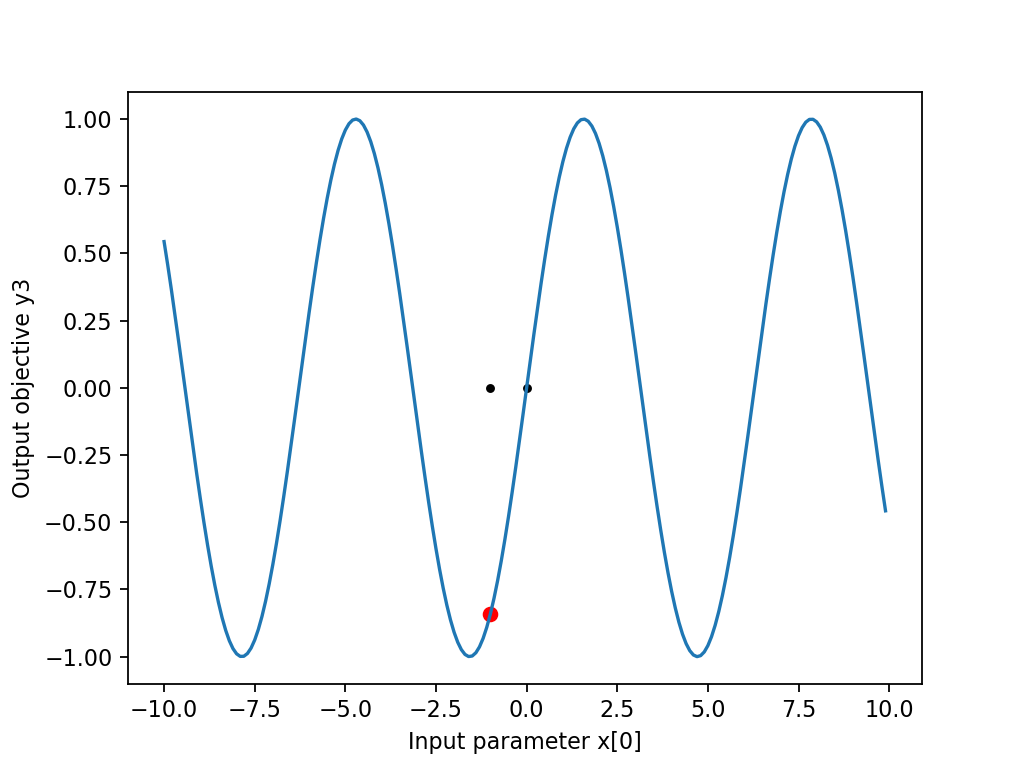

[-1.] -0.8414709848078965


In [12]:
x_history = []
y_history = []
#find first greater than 0
result = minimize(y3, [x0], options={'disp': True}, method='L-BFGS-B', bounds=((-1., 10.),))

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)
#never climbed the gradient and found min at the bound
#gradient sensative to initial conditions

So gradient-based approaches do not always find the desired local minimum! Let's try a non-gradient-based algorithm:

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 26
         Function evaluations: 52


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


<IPython.core.display.Javascript object>


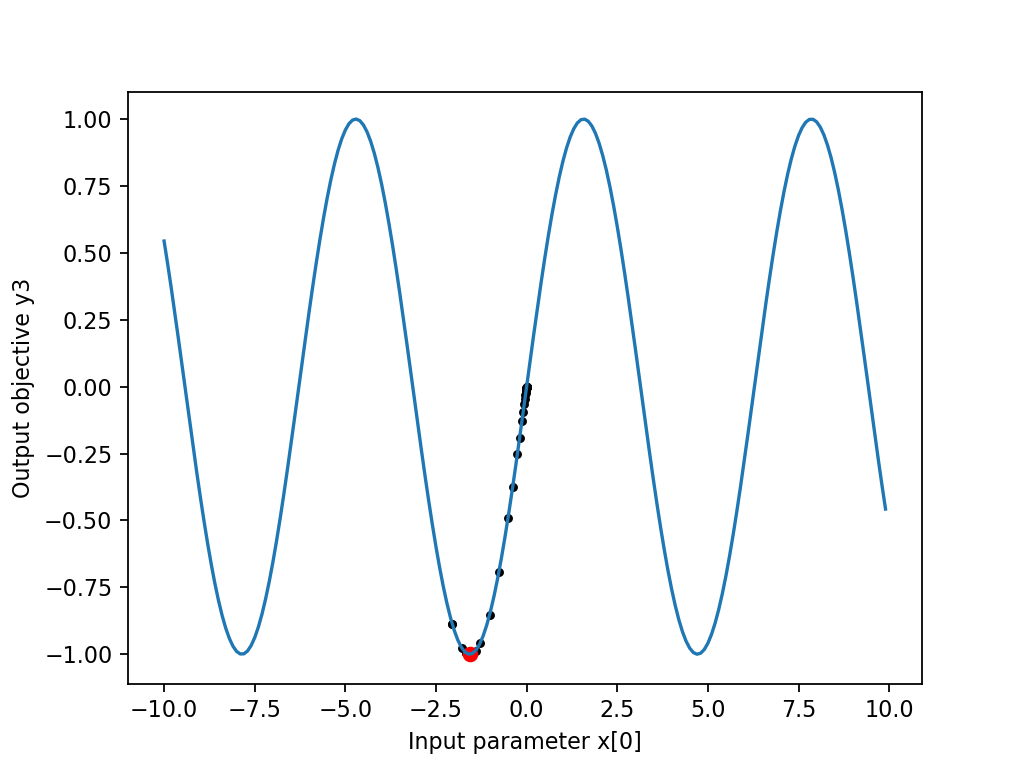

[-1.5708125] -0.9999999998692137


In [13]:
x_history = []
y_history = []
#doesnt compute slopes, just makes "hops" for local improvement
result = minimize(y3, [x0], options={'disp': True}, method='Nelder-Mead', bounds=((-1., 10.),))

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)

But this algorithm does not respect bounds. We can manually implement them by hard coding our function to be optimized to return a very large error value when parameters are out of bounds:

In [14]:
def y3(x):
    """
    The argument 'x' is an array of length 1.
    """
    for xi, bi in zip(x, bounds):
        #if any outside of bounds
        if not bi[0] <= xi <= bi[1]:
            return 1e9
    x_history.append(x)
    y = np.sin(x[0])
    y_history.append(y)
    return y

Optimization terminated successfully.
         Current function value: -0.841403
         Iterations: 30
         Function evaluations: 60


<IPython.core.display.Javascript object>


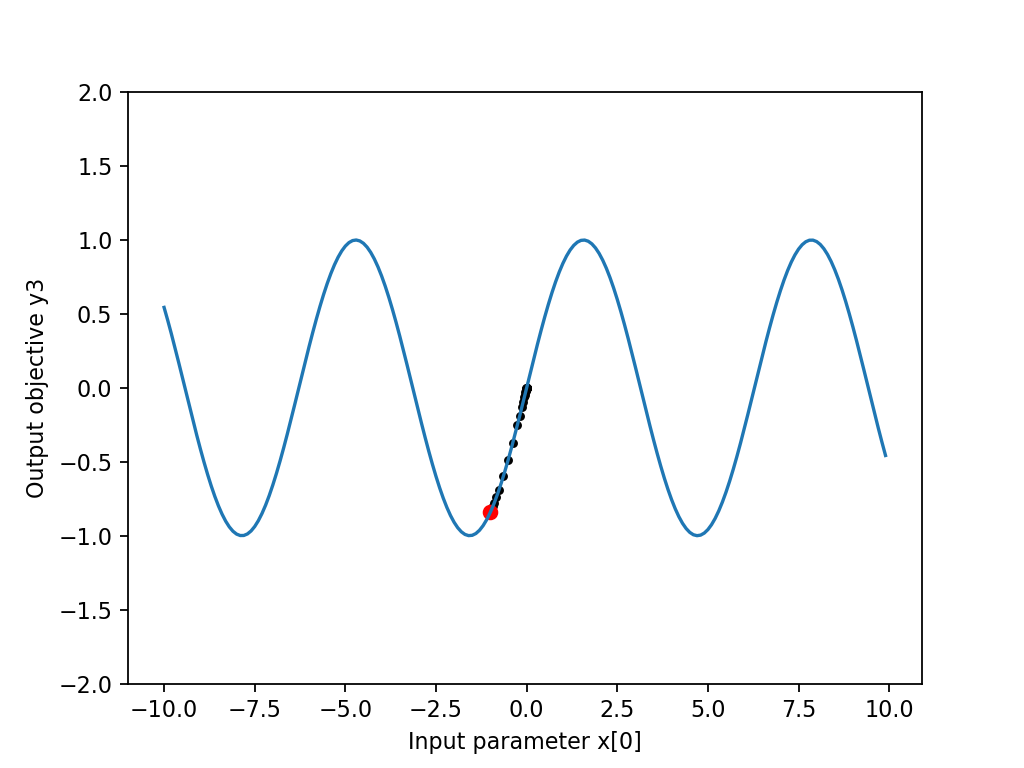

[-0.999875] -0.8414034404458473


In [15]:
x_history = []
y_history = []
bounds=((-1., 10.),)

result = minimize(y3, [x0], options={'disp': True}, method='Nelder-Mead')

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.ylim((-2., 2.))
plt.show()

print(result.x, result.fun)
#for non gradient base algorithms 

This algorithm, also known as "Simplex", only wants to look locally. It's a good "polisher", but we need a better way to search the whole bounded range. "Basinhopping" or "Simulated annealing" is good for this:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping

In every iteration, this algorithm will generate new parameters by taking "steps" from a previously visited point in the parameter space. Then it will try to use a local minimizer to polish the result. The initial stepsize can be specified, and with every iteration, the "temperature" decreases, which reduces the stepsize and decreases the error tolerance.

In [17]:
#start off with high 'temperature' parameter to make large jumps
#over time, variables that fall into small error spaces will be kept in list
#then it will take all locally found small error variables and populate 
from scipy.optimize import basinhopping

basinhopping step 0: f -0.841403
basinhopping step 1: f -0.841413 trial_f -0.841413 accepted 1  lowest_f -0.841413
found new global minimum on step 1 with function value -0.841413
basinhopping step 2: f -0.841411 trial_f -0.841411 accepted 1  lowest_f -0.841413
basinhopping step 3: f -0.841411 trial_f 1e+09 accepted 0  lowest_f -0.841413
basinhopping step 4: f -0.841411 trial_f 1e+09 accepted 0  lowest_f -0.841413
basinhopping step 5: f -0.841411 trial_f 1e+09 accepted 0  lowest_f -0.841413
basinhopping step 6: f -1 trial_f -1 accepted 1  lowest_f -1
found new global minimum on step 6 with function value -1
basinhopping step 7: f -1 trial_f -1 accepted 1  lowest_f -1
found new global minimum on step 7 with function value -1
basinhopping step 8: f -0.841414 trial_f -0.841414 accepted 1  lowest_f -1
basinhopping step 9: f -0.841458 trial_f -0.841458 accepted 1  lowest_f -1
basinhopping step 10: f -0.841458 trial_f 1e+09 accepted 0  lowest_f -1
basinhopping step 11: f -0.841458 trial_f 1e

<IPython.core.display.Javascript object>


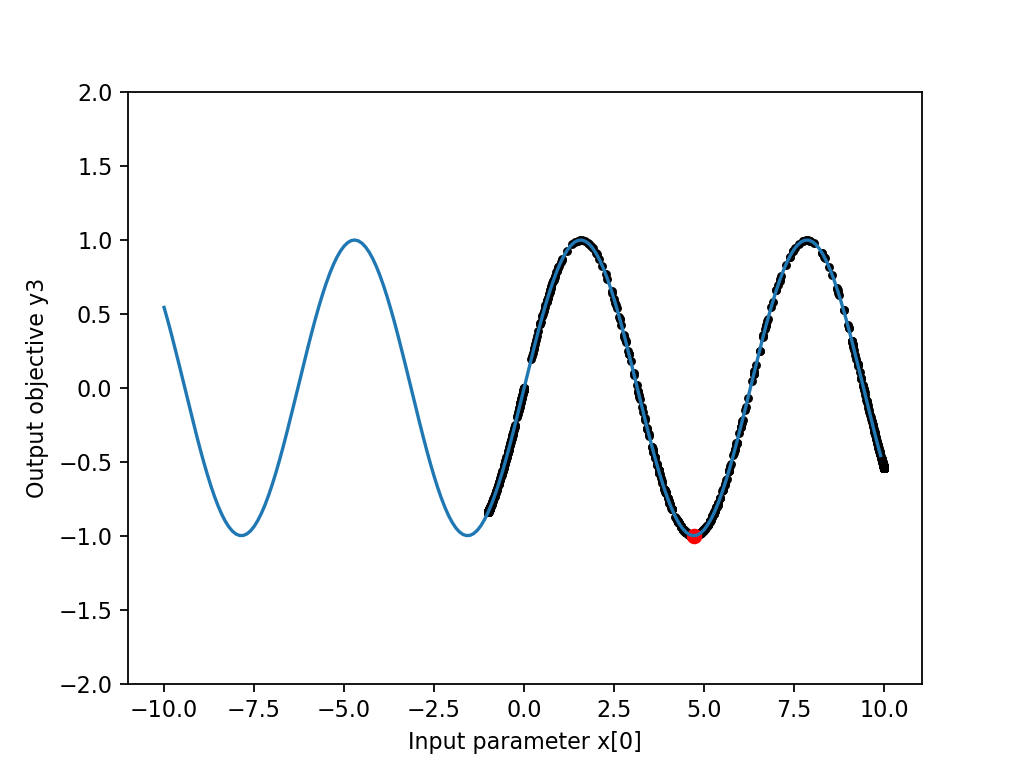

[4.71238845] -0.9999999999998589


In [18]:
''' conceptual - boiling pot of water - decrease the temperature to find local molecules of error values
and apply parameters'''


x_history = []
y_history = []
#bound length is 11
bounds=((-1., 10.),)
#jump within half the length of bounds
#default will find one local minmum, but if we increase step size it can explore entire parameter space
stepsize = 0.5 * (bounds[0][1] - bounds[0][0])
#Nelder-Mead - another local minimizer to pass in
result = basinhopping(y3, [x0], minimizer_kwargs={'method': 'Nelder-Mead'}, stepsize=stepsize, disp=True)
#can pass in tolerance to Nelder-Mead to do less function evaluations
#can pass in null-minimizer - pass back current error value - no local polishing
plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.ylim((-2., 2.))
plt.show()

print(result.x, result.fun)
#find hints within local minimum- broad sampling 
#big jumps --> smaller --> candidate root found
#solved the problem

In [ ]:
#grid search- find minimum within a local space and can apply a local minimizer
#needle and a haystack, one point to find error, might need 1000 function evaluations

## 4. Perform bounded parameter optimization on the input resistance of a NEURON section

In [19]:
from neuron import h
h.load_file('stdrun.hoc')

1.0

In [20]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('pas')

soma_pas_g0 = soma(0.5).pas.g

h.tstop = 400.
v_init = -65.
h.v_init = v_init
soma(0.5).pas.e = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = -0.05  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

In [21]:
def get_R_inp(t, v, i_amp, baseline_window=(195., 200.),  measurement_window=(395., 400.)):
    baseline_indexes = np.where((baseline_window[0] <= t) & (t < baseline_window[1]))
    measurement_indexes = np.where((measurement_window[0] <= t) & (t < measurement_window[1]))
    baseline_v = np.mean(v[baseline_indexes])
    measurement_v = np.mean(v[measurement_indexes])
    delta_v = abs(baseline_v - measurement_v)
    R_inp = (delta_v / 1000.) / (abs(i_amp) / 1e9) / 1e6 # convert mV to V, nA to A, and Ohm to MegaOhm
    return R_inp

def get_soma_R_inp_error(x, target, bounds, sim_history):
    for xi, bi in zip(x, bounds):
        if not bi[0] <= xi <= bi[1]:
            return 1e9
    soma(0.5).pas.g = x[0]
    h.run()
    t_array = np.array(t)
    v_array = np.array(soma_voltage)
    i_amp = step_current_stim.amp
    soma_R_inp = get_R_inp(t_array, v_array, i_amp)
    #square of the difference between measured and target
    error = (target - soma_R_inp) ** 2.
    #key value pairs t.... soma Vm
    this_sim_summary = {}
    this_sim_summary['t'] = t_array
    this_sim_summary['soma_voltage'] = v_array
    this_sim_summary['soma_R_inp'] = soma_R_inp
    this_sim_summary['error'] = error
    #x as a tuple to use as a key
    #good for querying too, take query and convert to tuple
    #to check if query is done before
    #good for finding specific synapse at an area and cash these know that this copy is cashed to pull again
    #cash - search history - save pointer to result if serialized 
    sim_history[tuple(x)] = this_sim_summary
    #squared error
    return error

In [22]:
bounds = ((1e-12, 0.1),)
stepsize = 0.5 * (bounds[0][1] - bounds[0][0])
x0 = [soma_pas_g0]
target_soma_R_inp = 150.
#store t array, soma Vm, outcome of Rinp and error function float into dict
#per x0 input its associated with its own keys and values of simulations
#to know the values passed in for the x0, but cannot use an iterable value, have to convert array into tuple
sim_history = {} # {x0: {'t': array, 'soma_voltage': array, 'soma_R_inp': float, 'error': float}

result = basinhopping(get_soma_R_inp_error, x0, stepsize=stepsize, disp=True, 
                     minimizer_kwargs={'method': 'Nelder-Mead', 'args': (target_soma_R_inp, bounds, sim_history)})

basinhopping step 0: f 0.000182134
basinhopping step 1: f 0.000182134 trial_f 1e+09 accepted 0  lowest_f 0.000182134
basinhopping step 2: f 0.000182134 trial_f 1e+09 accepted 0  lowest_f 0.000182134
basinhopping step 3: f 0.000182134 trial_f 1e+09 accepted 0  lowest_f 0.000182134
basinhopping step 4: f 2.38814e-05 trial_f 2.38814e-05 accepted 1  lowest_f 2.38814e-05
found new global minimum on step 4 with function value 2.38814e-05
basinhopping step 5: f 0.000152395 trial_f 0.000152395 accepted 1  lowest_f 2.38814e-05
basinhopping step 6: f 0.000152395 trial_f 1e+09 accepted 0  lowest_f 2.38814e-05
basinhopping step 7: f 1.19343e-05 trial_f 1.19343e-05 accepted 1  lowest_f 1.19343e-05
found new global minimum on step 7 with function value 1.19343e-05
basinhopping step 8: f 1.01027e-05 trial_f 1.01027e-05 accepted 1  lowest_f 1.01027e-05
found new global minimum on step 8 with function value 1.01027e-05
basinhopping step 9: f 1.01027e-05 trial_f 1e+09 accepted 0  lowest_f 1.01027e-05
ba

basinhopping step 91: f 7.83123e-07 trial_f 7.83123e-07 accepted 1  lowest_f 7.83123e-07
found new global minimum on step 91 with function value 7.83123e-07
basinhopping step 92: f 8.88972e-06 trial_f 8.88972e-06 accepted 1  lowest_f 7.83123e-07
basinhopping step 93: f 8.88972e-06 trial_f 1e+09 accepted 0  lowest_f 7.83123e-07
basinhopping step 94: f 3.07634e-05 trial_f 3.07634e-05 accepted 1  lowest_f 7.83123e-07
basinhopping step 95: f 6.30493e-06 trial_f 6.30493e-06 accepted 1  lowest_f 7.83123e-07
basinhopping step 96: f 6.30493e-06 trial_f 1e+09 accepted 0  lowest_f 7.83123e-07
basinhopping step 97: f 6.30493e-06 trial_f 1e+09 accepted 0  lowest_f 7.83123e-07
basinhopping step 98: f 1.33232e-05 trial_f 1.33232e-05 accepted 1  lowest_f 7.83123e-07
basinhopping step 99: f 2.60845e-05 trial_f 2.60845e-05 accepted 1  lowest_f 7.83123e-07
adaptive stepsize: acceptance rate 0.370000 target 0.500000 new stepsize 0.0405 old stepsize 0.045
basinhopping step 100: f 3.35969e-06 trial_f 3.359

In [23]:
print(result)
#fun - the sqaured error values

                        fun: 7.831232757310002e-07
 lowest_optimization_result:  final_simplex: (array([[0.00053051],
       [0.00053054]]), array([7.83123276e-07, 4.30676737e-05]))
           fun: 7.831232757310002e-07
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 23
        status: 0
       success: True
             x: array([0.00053051])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2691
                        nit: 100
                          x: array([0.00053051])


<IPython.core.display.Javascript object>


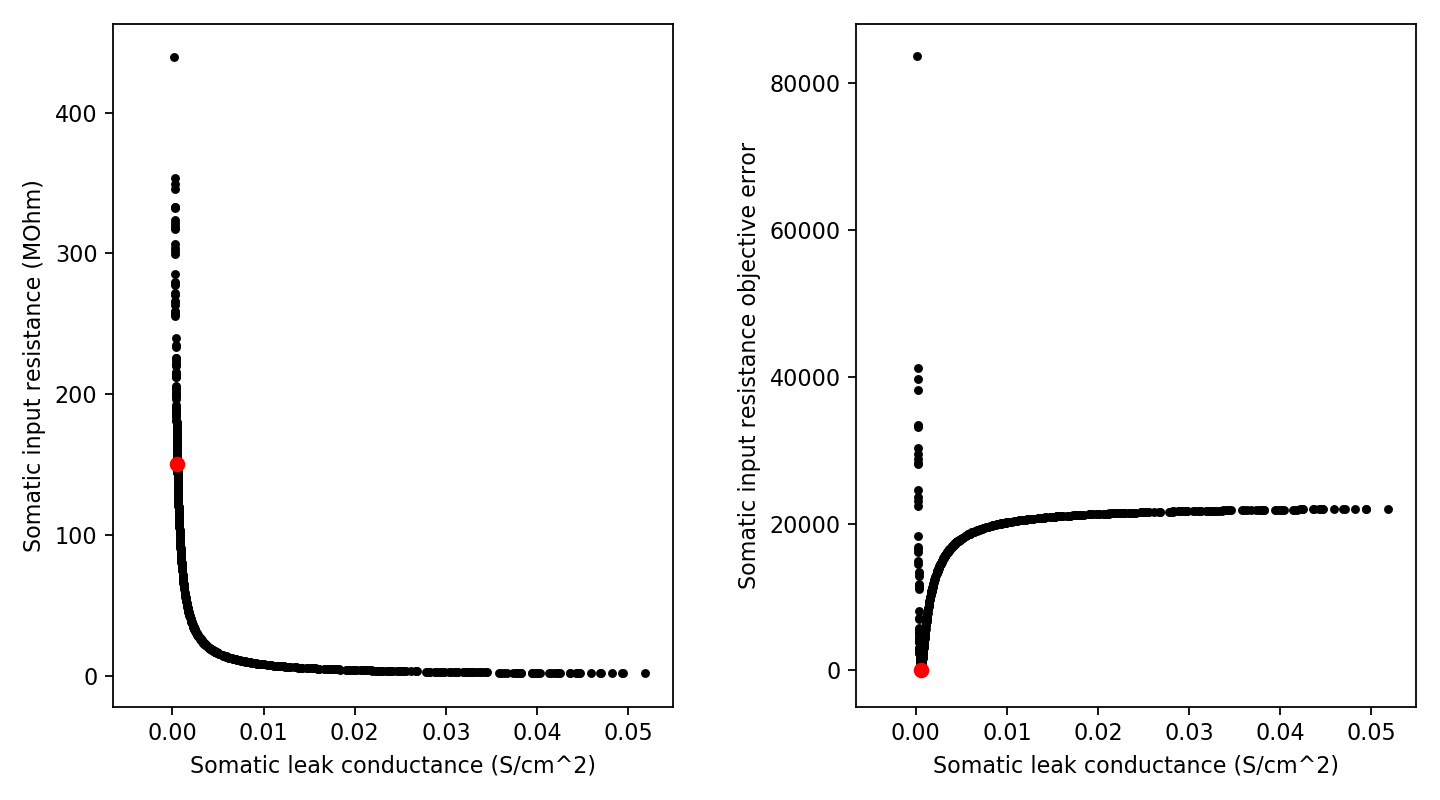

In [24]:
#x array values tested are keys in sim history dictionary
#values - dictionaries of the simulation attributes
fig, axes = plt.subplots(1, 2, figsize=(9., 5.))
for xi, this_sim_summary in sim_history.items():
    axes[0].scatter(xi[0], this_sim_summary['soma_R_inp'], marker='.', c='k')
    axes[1].scatter(xi[0], this_sim_summary['error'], marker='.', c='k')
axes[0].scatter(result.x[0], sim_history[tuple(result.x)]['soma_R_inp'], marker='o', c='r')
axes[1].scatter(result.x[0], result.fun, marker='o', c='r')
axes[0].set_xlabel('Somatic leak conductance (S/cm^2)')
axes[1].set_xlabel('Somatic leak conductance (S/cm^2)')
axes[0].set_ylabel('Somatic input resistance (MOhm)')
axes[1].set_ylabel('Somatic input resistance objective error')
fig.tight_layout(w_pad=3.)
fig.show()

optimal_pas_g = result.x

## 5. Introduction to NMODL, the language used to specify ion channel mechanisms in NEURON

Here are the contents of the built-in NEURON mechanism defined in 'hh.mod':

    TITLE hh.mod   squid sodium, potassium, and leak channels

    COMMENT
     This is the original Hodgkin-Huxley treatment for the set of sodium, 
      potassium, and leakage channels found in the squid giant axon membrane.
      ("A quantitative description of membrane current and its application 
      conduction and excitation in nerve" J.Physiol. (Lond.) 117:500-544 (1952).)
     Membrane voltage is in absolute mV and has been reversed in polarity
      from the original HH convention and shifted to reflect a resting potential
      of -65 mV.
     Remember to set celsius=6.3 (or whatever) in your HOC file.
     See squid.hoc for an example of a simulation using this model.
     SW Jaslove  6 March, 1992
    ENDCOMMENT

    UNITS {
            (mA) = (milliamp)
            (mV) = (millivolt)
        (S) = (siemens)
    }

    NEURON {
            SUFFIX hh
            USEION na READ ena WRITE ina
            USEION k READ ek WRITE ik
            NONSPECIFIC_CURRENT il
            RANGE gnabar, gkbar, gl, el, gna, gk
            GLOBAL minf, hinf, ninf, mtau, htau, ntau
    }

    PARAMETER {
            gnabar = .12 (S/cm2)	<0,1e9>
            gkbar = .036 (S/cm2)	<0,1e9>
            gl = .0003 (S/cm2)	<0,1e9>
            el = -54.3 (mV)
    }

    STATE {
            m h n
    }

    ASSIGNED {
            v (mV)
            celsius (degC)
            ena (mV)
            ek (mV)

        gna (S/cm2)
        gk (S/cm2)
            ina (mA/cm2)
            ik (mA/cm2)
            il (mA/cm2)
            minf hinf ninf
        mtau (ms) htau (ms) ntau (ms)
    }
    
    BREAKPOINT {
            SOLVE states METHOD cnexp
            gna = gnabar*m*m*m*h
        ina = gna*(v - ena)
            gk = gkbar*n*n*n*n 
        ik = gk*(v - ek)      
            il = gl*(v - el)
    }

    #vint = -65 compute rates at the vint value at equilibrium, there will be a equilibr. period for state variables to have no change
    INITIAL {
        rates(v)
        m = minf
        h = hinf
        n = ninf
    }
    #instantaneous states dmdt, diff equation, given the initial states 
    DERIVATIVE states {  
            rates(v)
            m' =  (minf-m)/mtau  #how far is it from target(Driving force)/the time constant(kinetics) = rate of change of m
            h' = (hinf-h)/htau
            n' = (ninf-n)/ntau
    }

    :LOCAL q10

    
    PROCEDURE rates(v(mV)) {  :Computes rate and other constants at current v.
                          :Call once from HOC to initialize inf at resting v.
            LOCAL  alpha, beta, sum, q10
            TABLE minf, mtau, hinf, htau, ninf, ntau DEPEND celsius FROM -100 TO 100 WITH 200
    #set to 6.3 C by default, so q10 = 1
    UNITSOFF
            q10 = 3^((celsius - 6.3)/10)
                    :"m" sodium activation system
            alpha = .1 * vtrap(-(v+40),10)
            beta =  4 * exp(-(v+65)/18)
            sum = alpha + beta
        mtau = 1/(q10*sum)
            minf = alpha/sum
                    :"h" sodium inactivation system
            #scaling terms skeleton equations to fit equations
            #multi-phasic exponential rise equa with respect to voltage
            alpha = .07 * exp(-(v+65)/20)
            beta = 1 / (exp(-(v+35)/10) + 1)
            sum = alpha + beta
        htau = 1/(q10*sum)
            hinf = alpha/sum
                    :"n" potassium activation system
            alpha = .01*vtrap(-(v+55),10) 
            beta = .125*exp(-(v+65)/80)
        sum = alpha + beta
            ntau = 1/(q10*sum)
            ninf = alpha/sum
    }
    #vtrap = x/(exp(x/y) - 1) if x = 0, it will be undefined
    FUNCTION vtrap(x,y) {  :Traps for 0 in denominator of rate eqns.
            if (fabs(x/y) < 1e-6) {
                    vtrap = y*(1 - x/y/2)
            }else{
                    vtrap = x/(exp(x/y) - 1)
            }
    }

    UNITSON

This mechanism specifies 3 distinct ion channels in one!
 - Passive leak conductance
 - Hodkin-Huxley-style sodium conductance with voltage-dependent activation gate and voltage-dependent inactivation gate
 - Hodkin-Huxley-style delayed rectifier potassium conductance with voltage-dependent activation gate
 
## Exercise: Let's plot the voltage dependence of the "m", "h", and "n" gates:
 - Use the rates(v) function defined in the .mod file to create python functions that plot minf, hinf, and ninf as functions of v

In [25]:
q10 = 1.  # For this purpose, temperature = 6.3 and the temperature sensitivity factor = 1.

def vtrap(x, y):
    if abs(x/y) < 1e-6:
        return y * (1. - x / y / 2.)
    else:
        return x / (np.exp(x / y) - 1.)

In [37]:
#how to long it takes to reach target activation (Na)
def mtau(v):
    alpha = .1 * vtrap(-(v+40), 10)
    beta =  4 * np.exp(-(v+65)/18)
    this_sum = alpha + beta
    return 1. / (q10 * this_sum)
#what is that target value of m if v is constant
def minf(v):
    alpha = .1 * vtrap(-(v+40), 10)
    beta =  4 * np.exp(-(v+65)/18)
    this_sum = alpha + beta
    return alpha / this_sum

def htau(v):
    # fill in
    alpha = .07 * np.exp(-(v+65)/20)
    beta = 1 / (np.exp(-(v+35)/10) + 1)
    this_sum = alpha + beta 
    
    return 1./(q10 * this_sum)

def hinf(v):
    # fill in
    alpha = .07 * np.exp(-(v+65)/20)
    beta = 1 / (np.exp(-(v+35)/10) + 1)
    this_sum = alpha + beta 
    
    return alpha/this_sum

def ntau(v):
    # fill in
    alpha = .01*vtrap(-(v+55),10) 
    beta = .125*np.exp(-(v+65)/80)
    this_sum = alpha + beta 


    return 1./(q10*this_sum)
    
def ninf(v):
    # fill in
    alpha = .01*vtrap(-(v+55),10) 
    beta = .125*np.exp(-(v+65)/80)
    this_sum = alpha + beta 
    
    return alpha/this_sum

<IPython.core.display.Javascript object>


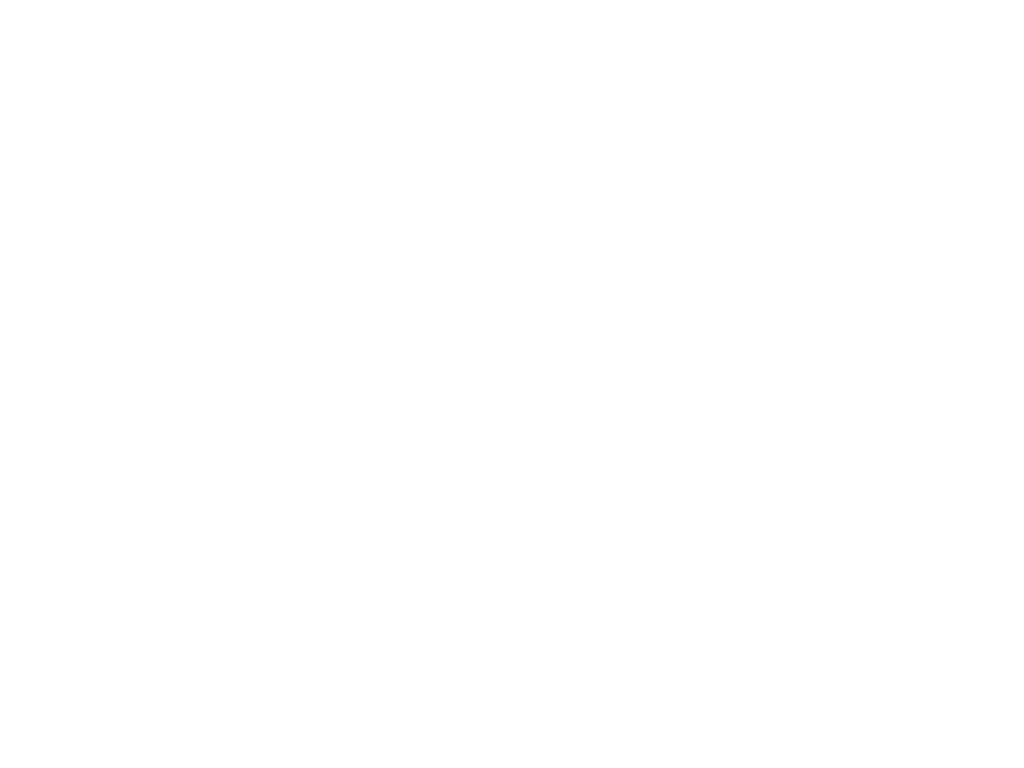

NameError: name 'minh' is not defined

In [27]:
v = np.arange(-100., 100., 0.1)

plt.figure()
plt.plot(v, minh(v))

If a function expects a float, you can pass in a vector and get back a vector if you wrap it with np.vectorize()!

<IPython.core.display.Javascript object>


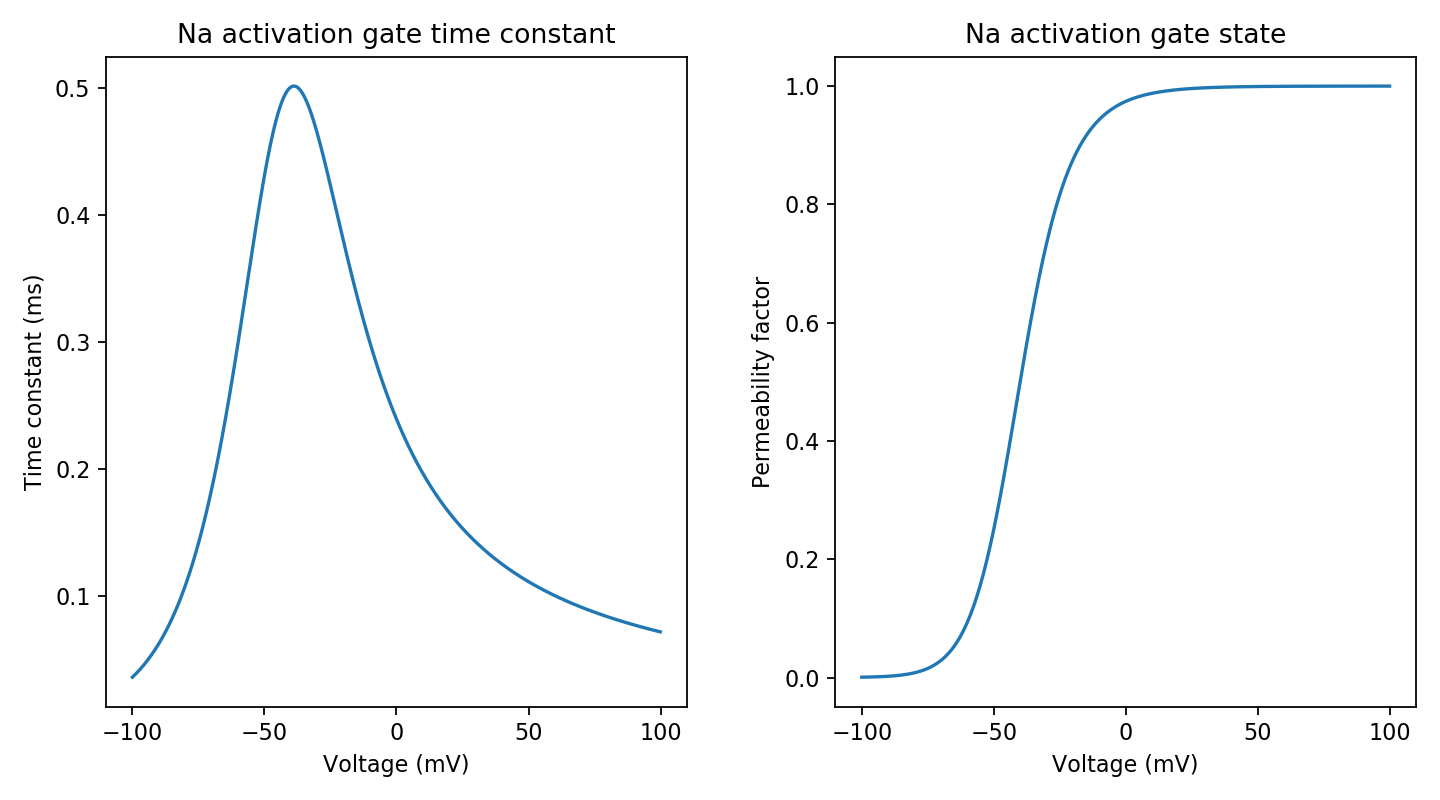

In [28]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(mtau)(v))
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Na activation gate time constant')
axes[1].plot(v, np.vectorize(minf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('Na activation gate state')
fig.tight_layout(w_pad=3.)
fig.show()
#large time constant means more time = slow to equilibrate
#at -100, there is a fast activation, but as it approaches the vhalf = -40 (peak) - spike threshold, there is a slow
#activation
#dmdt or the slope is max at -40mv which is the vhalf
#all channels open maxes out at +10 or +20 - permeability - max conductance - voltage cannot above a certain value
#max activation is between Ena and Ek - highest permeability
#Nernst - overall net potential 
#+50mv all activation gates are open - permeability
#Na activation gate state - value of minf is the voltage (-50mv) where how many channels are open - permeability
#time constant tells you the time to reach that permeability

<IPython.core.display.Javascript object>


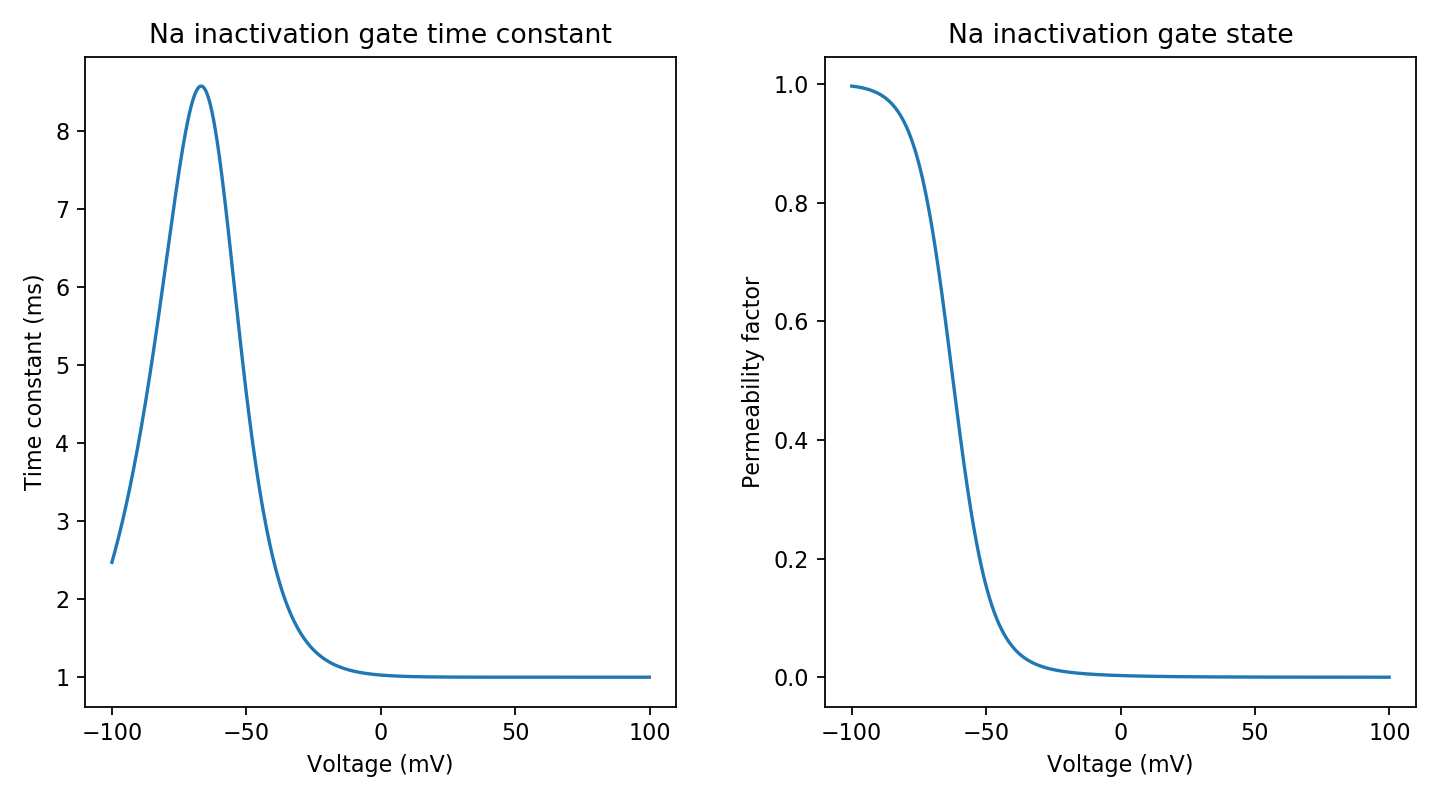

In [33]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(htau)(v))
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Na inactivation gate time constant')
axes[1].plot(v, np.vectorize(hinf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('Na inactivation gate state')
fig.tight_layout(w_pad=3.)
fig.show()
#really slow at hyperpolized potentials - refract period dependent on inactivation gate moving back
#to open state - really slow
#fast above zero
#how long does it take at a target potential
#oscillations occur to keep neuron on pace to fire 
#TTX - K has different kinetics, K channels allow for the after hyperpolarization

<IPython.core.display.Javascript object>


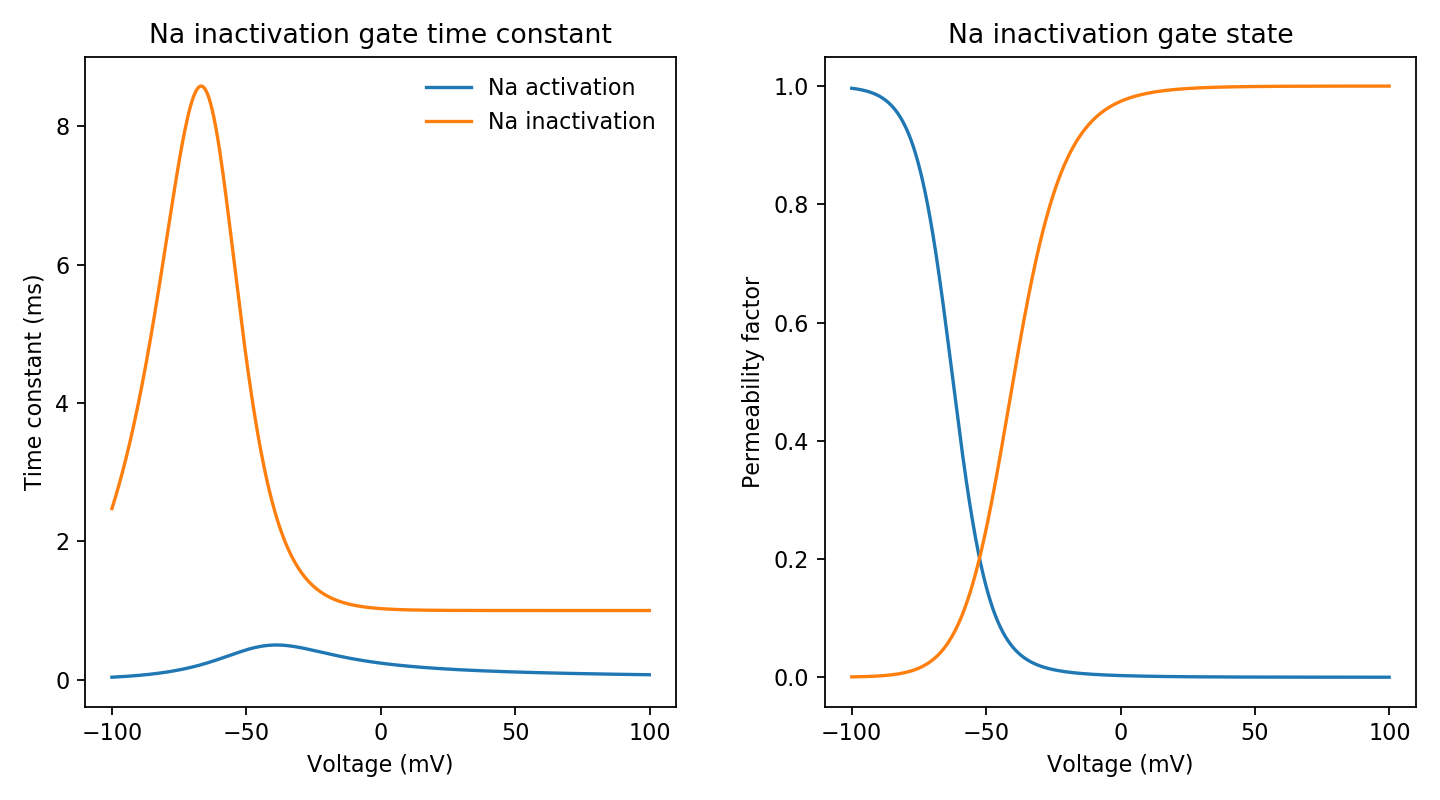

In [35]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(mtau)(v), label='Na activation')
axes[0].plot(v, np.vectorize(htau)(v), label='Na inactivation')
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Na inactivation gate time constant')
axes[1].plot(v, np.vectorize(hinf)(v))
axes[1].plot(v, np.vectorize(minf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('Na inactivation gate state')
axes[0].legend(loc='best', frameon=False)
fig.tight_layout(w_pad=3.)
fig.show()
'''#cross 'window current' = below spike threshold, not spiking so no action current but passing non zero current
#activation is way faster than inactivation - below 2 ms - spiking is fast'''
#recovery is slow above 2ms - needs to sit at rest to have more current and recover channels
#low input resistance - alot of k channels - harder to drive to excite
#think of resistance in terms of excitability first - GABA inhibition will have lower K Resistance
#at high input resistance - only small amound of Na and K channels to allow for spikes - 
#so will allow for recovery and hyperpolarization to have another spike again
#high g = low R
'''shunting inhibition - alot of GABA inhibition - no current going through, but are open - takes "more" to excite 
#this is a decrease in input resistance''' 

<IPython.core.display.Javascript object>


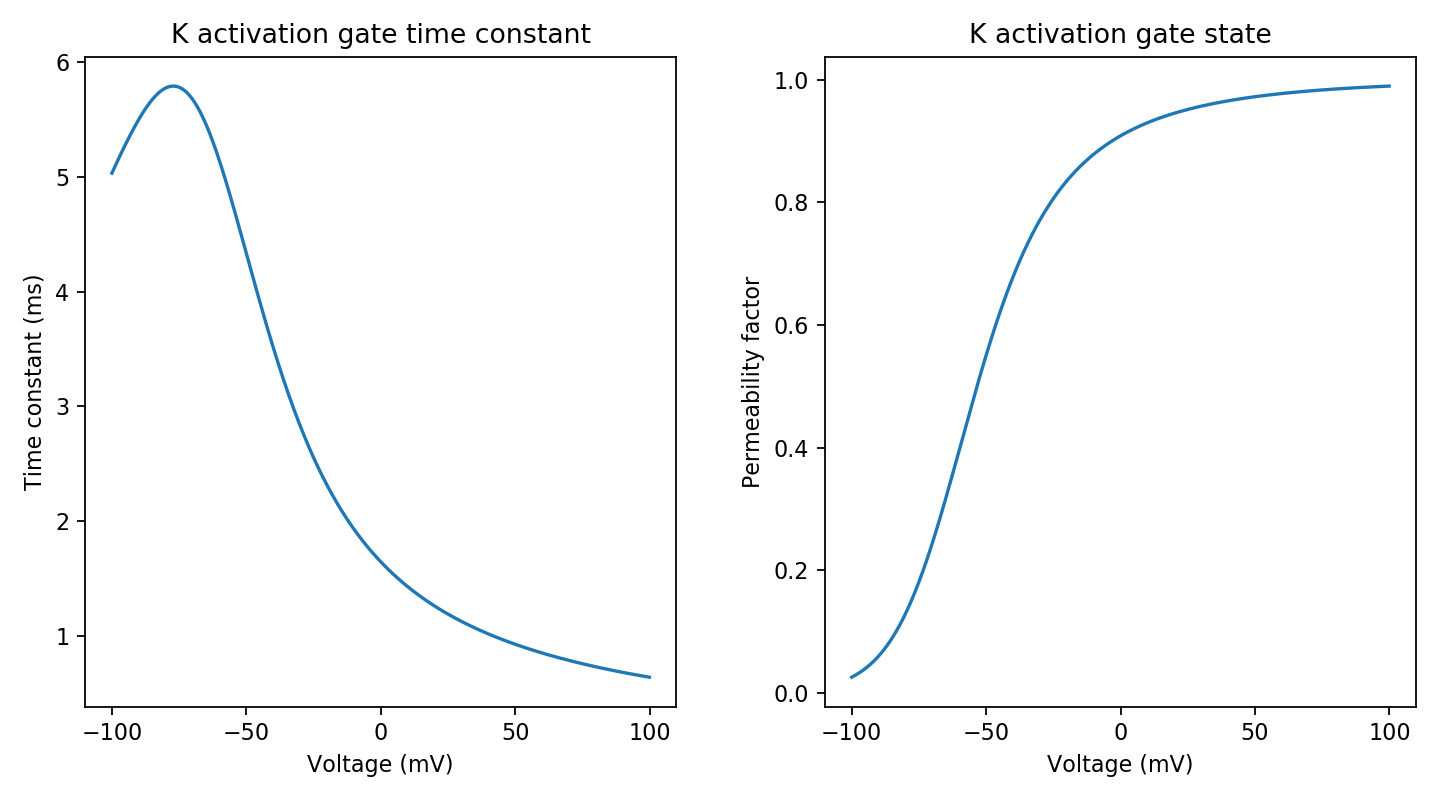

In [38]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(ntau)(v))
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('K activation gate time constant')
axes[1].plot(v, np.vectorize(ninf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('K activation gate state')
fig.tight_layout(w_pad=3.)
fig.show()
#vhalf = -60mV
#5 - 6 ms magnitude so alot slower
#near - 50mV - the activate gate state is around the same but the Na is faster so it will win out first for activation
#competition of activation states
#non-zero at rest - K channels open
#time constant about movement - at +50mV K channels are still open
#time constant is large at -70 - for hyperpolerization
# refract contributed by the the slow deactivation kinetics - closing an activation gate
#inactivate - unit as secondary unit as inactivator 

<IPython.core.display.Javascript object>


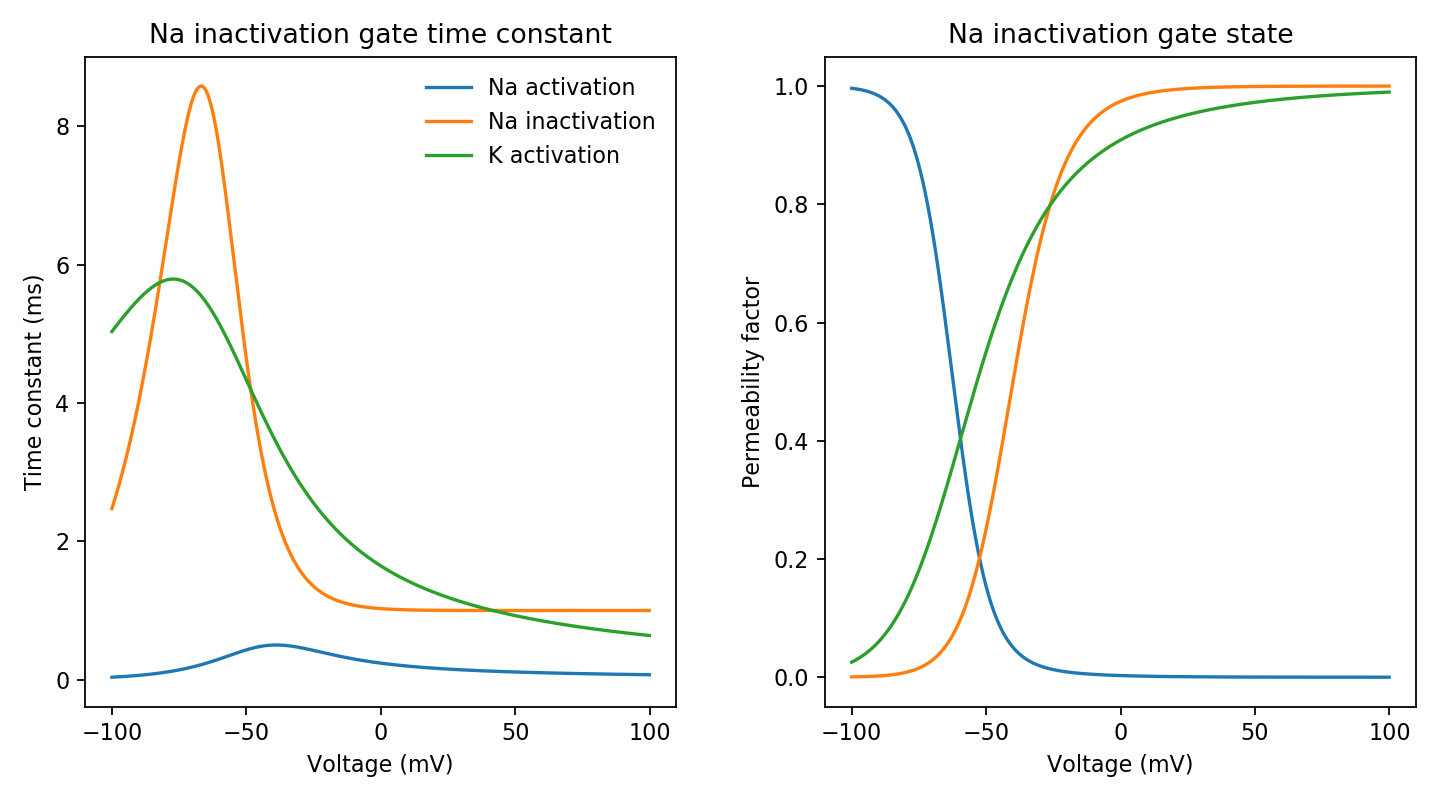

In [53]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(mtau)(v), label='Na activation')
axes[0].plot(v, np.vectorize(htau)(v), label='Na inactivation')
axes[0].plot(v, np.vectorize(ntau)(v), label ='K activation')
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Na inactivation gate time constant')
axes[1].plot(v, np.vectorize(hinf)(v))
axes[1].plot(v, np.vectorize(minf)(v))
axes[1].plot(v, np.vectorize(ninf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('Na inactivation gate state')
axes[0].legend(loc='best', frameon=False)
fig.tight_layout(w_pad=3.)
fig.show()
#fig.savefig('ActivationCurves.png')
#initiation of events - spikes is because of Na act ; inact kinetics while the return to rest is because of 
#K activation, K g, and RP, (and Na/K pumps - slower time scale doesnt contribute at ms time scale), and leak K 

## 6. Insert "active" voltage-dependent "Hodgkin-Huxley" ion channels

In [41]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('hh')

h.tstop = 600.
v_init = -65.
h.v_init = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = 0.1  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

<IPython.core.display.Javascript object>


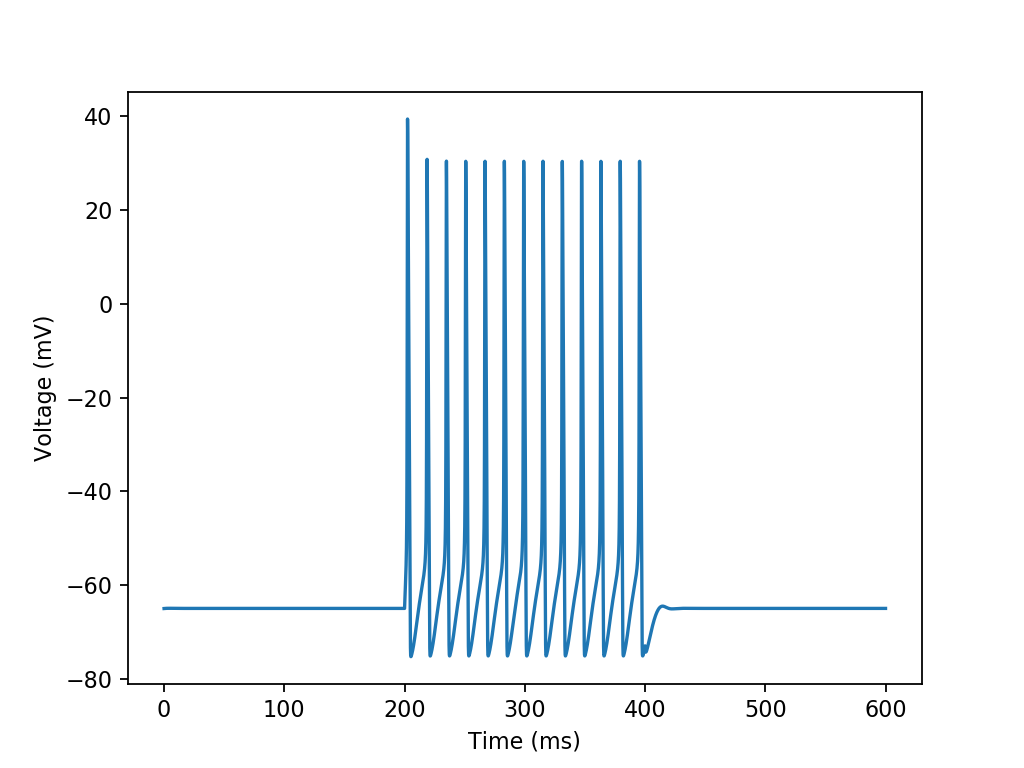

Text(0.5, 0, 'Time (ms)')

In [42]:
h.run()
plt.figure()
plt.plot(t, soma_voltage)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
#smaller current injection might cause all to be same height

In [44]:
hh_mech = soma(0.5).hh

In [47]:
hh_mech.gkbar   # tab to complete #gkbar - peak conductance if all open gk = gkbar * n^4
#functions of voltage

0.036

Recordings can be established for the 3 ion channel conductances:

In [48]:
#now think of hh attributes in time scales
gl = h.Vector()
gl.record(soma(0.5).hh._ref_gl, h.dt)
gna = h.Vector()
gna.record(soma(0.5).hh._ref_gna, h.dt)
gk = h.Vector()
gk.record(soma(0.5).hh._ref_gk, h.dt)

Vector[6]

<IPython.core.display.Javascript object>


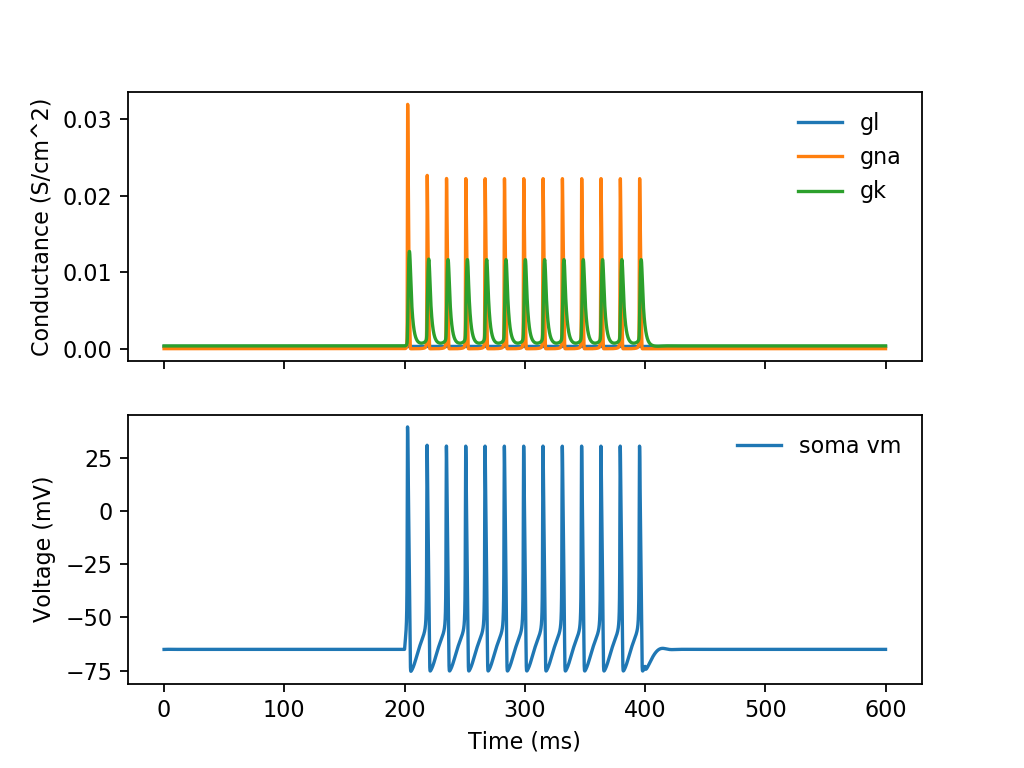

Text(0.5, 0, 'Time (ms)')

In [49]:
#gl = leak conductance
#gk slower to rise slower to close
#gna - faster to rise faster to close
h.run()
fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(t, gl, label='gl')
axes[0].plot(t, gna, label='gna')
axes[0].plot(t, gk, label='gk')
axes[0].legend(loc='best', frameon=False)
axes[1].plot(t, soma_voltage, label='soma vm')
axes[1].legend(loc='best', frameon=False)
axes[0].set_ylabel('Conductance (S/cm^2)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_xlabel('Time (ms)')

In [50]:
gkbar0 = soma(0.5).hh.gkbar
gnabar0 = soma(0.5).hh.gnabar
gl0 = soma(0.5).hh.gl
T0 = h.celsius

In [51]:
#record when neuron fire spikes 
#event detector to hold spike times
#spikedetector= netcon (network connection) => record when cell crosses some threshold
#spike detector creates spike event and will deliver to the next synapse
#example: 10 spikes - 10 events - 1 netcon from axon to dendrite 
spike_times = h.Vector()
#what are you monitering - the ref_v the voltage of the soma 
#can measure Ca concentrations
#put into axon to detect event
spike_detector = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
#delay - if axon is long - takes time for event to take time

spike_detector.delay = 0.  # ms

#what value of voltage to consider spike - Na spikes at vhalf - 50mV - cell can cross and not generate spike
#want to put it at a level that this wont happen
spike_detector.threshold = -10.  # mV
#build vector and tell what vector you want to record
spike_detector.record(spike_times)
#spike_times array of spike times

0.0

<IPython.core.display.Javascript object>


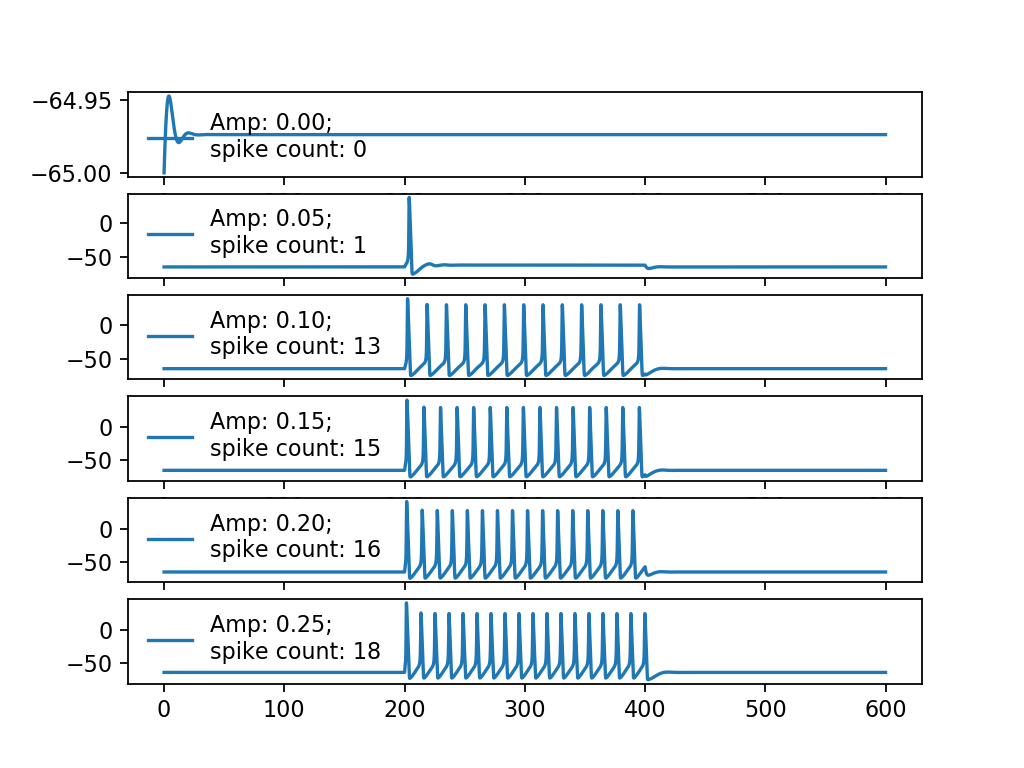

Amp: 0.00;
spike times: []
Amp: 0.05;
spike times: [203.55]
Amp: 0.10;
spike times: [202.175 218.45  234.525 250.575 266.65  282.7   298.75  314.825 330.875
 346.95  363.    379.075 395.125]
Amp: 0.15;
spike times: [201.7   215.8   229.6   243.375 257.15  270.95  284.725 298.5   312.275
 326.05  339.825 353.625 367.4   381.175 394.95 ]
Amp: 0.20;
spike times: [201.425 214.35  226.9   239.4   251.925 264.425 276.95  289.45  301.975
 314.5   327.    339.525 352.025 364.55  377.05  389.575]
Amp: 0.25;
spike times: [201.275 213.375 225.05  236.675 248.325 259.95  271.575 283.225 294.85
 306.475 318.125 329.75  341.4   353.025 364.65  376.3   387.925 399.55 ]


In [52]:
#fi curves - 
#build array of injection amplitudes and append spike counts - simulation attributes - store in dictionary
#spike_attributes = []
#or Spike attribute = spike_count/duration = firing rate
#def:
#np.where to subset spike times within time window interested in for injection. 
#fi curve slope - firing rate = Spike_count/duration(step_current_duration) - Spikes/ms to spikes/s =Hertz 
#slope = hertz/nA (hertz/i) 
#have a bunch of curve injections and firing rate - fit line to get slope (FR/nA) -- curve fitting
#spike_attributes.append(attributes)#fiing_rate = spike_count / step_current_duration # convert from spikes / ms to spikes / s —> Hz 
#f-I curve slope = Hz/nA #+0.05 nA -> + 10 Hz
#np.curve_fit
step_current_stim.amp = 0.5
test_amp_vals = [0.05 * i for i in range(6)]
fig, axes = plt.subplots(len(test_amp_vals))
for i, amp in enumerate(test_amp_vals):
    step_current_stim.amp = amp
    h.run()
    print('Amp: %.2f;\nspike times: %s' % (amp, str(np.array(spike_times))))
    axes[i].plot(t, soma_voltage, label='Amp: %.2f;\nspike count: %i' % (amp, len(spike_times)))
    axes[i].legend(loc='best', frameon=False)
fig.show()

## 7. Challenge 1: Measure and plot an f-I curve

 - The relationship between input current (I) and output firing rate (f)
 - Make sure to only count spikes within the window of the step current injection

## 8. Challenge 2: Simultaneously optimize both somatic input resistance and the slope of the f-I curve.

 - Hint: x0 = [gl0, gnabar0, gkbar0]
 - How to construct a single error value that reflects 2 objectives?
 - Target f-I slope should be ~10 Hz / 0.05 nA
 - f-I slope should really only be calculated from values of I that produced more than one spike. ___/

Some papers to read for next week:

 - Stuart, Greg, and Nelson Spruston. "Determinants of voltage attenuation in neocortical pyramidal neuron dendrites." Journal of Neuroscience 18.10 (1998): 3501-3510. https://www.jneurosci.org/content/18/10/3501.full
 - Hoffman, Dax A., et al. "K+ channel regulation of signal propagation in dendrites of hippocampal pyramidal neurons." Nature 387.6636 (1997): 869-875. https://www.nature.com/articles/43119
 - Royeck, Michel, et al. "Role of axonal NaV1. 6 sodium channels in action potential initiation of CA1 pyramidal neurons." Journal of neurophysiology 100.4 (2008): 2361-2380.
 https://journals.physiology.org/doi/full/10.1152/jn.90332.2008